## This notebook is used for testing MTAOS communication with the AOS components: M1M3, M2, and hexapods

Step-by-step description of what we do can be found in 
Jira test case: https://jira.lsstcorp.org/secure/Tests.jspa#/testCase/LVV-T???? 

test on NTS first:

* Do all the callback messages look right?
* Look at the EFD notebooks at the same time. Is everything as expected?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import rubin_jupyter_utils.lab.notebook as nb
nb.utils.get_node()

Patching auth into notebook.base.handlers.IPythonHandler(notebook.base.handlers.AuthenticatedHandler) -> IPythonHandler(jupyterhub.singleuser.mixins.HubAuthenticatedHandler, notebook.base.handlers.AuthenticatedHandler)


'lsst-nts-kub06'

In [2]:
from lsst.ts import salobj
import asyncio
import os

import numpy as np
from matplotlib import pyplot as plt
from astropy.time import Time
from datetime import datetime, timedelta
import pandas as pd
import yaml

from lsst.ts.observatory.control.maintel.mtcs import MTCS, MTCSUsages
from lsst.ts.observatory.control import RotType
from astropy.coordinates import AltAz, ICRS, EarthLocation, Angle, FK5
import astropy.units as u

from aosTools import *

plt.jet();

<Figure size 432x288 with 0 Axes>

In [3]:
print(os.environ["OSPL_URI"])
print(os.environ["LSST_DDS_PARTITION_PREFIX"])
print(os.environ["LSST_DDS_DOMAIN_ID"])

file:///home/bxin/ts_ddsconfig/config/ospl-shmem.xml
ncsa
0


In [4]:
#index is an integter which helps avoid multple users starting same controller
script = salobj.Controller("Script", index=7)

In [5]:
mtcs = MTCS(script.domain)
mtcs.set_rem_loglevel(40)

In [6]:
await mtcs.start_task

elevation DDS read queue is full (100 elements); data may be lost
timeAndDate DDS read queue is full (100 elements); data may be lost
cameraCableWrap DDS read queue is full (100 elements); data may be lost
azimuth DDS read queue is full (100 elements); data may be lost
mountStatus DDS read queue is full (100 elements); data may be lost
mountPosition DDS read queue is full (100 elements); data may be lost
currentTargetStatus DDS read queue is full (100 elements); data may be lost
electrical DDS read queue is filling: 73 of 100 elements
electrical DDS read queue is full (100 elements); data may be lost
application DDS read queue is filling: 73 of 100 elements


[None, None, None, None, None, None, None, None, None, None]

powerSupplyData DDS read queue is full (100 elements); data may be lost
application DDS read queue is full (100 elements); data may be lost
actuators DDS read queue is filling: 74 of 100 elements


In [7]:
mtcs.components_attr

actuators DDS read queue is full (100 elements); data may be lost
pidData DDS read queue is full (100 elements); data may be lost


['mtmount',
 'mtptg',
 'mtaos',
 'mtm1m3',
 'mtm2',
 'mthexapod_1',
 'mthexapod_2',
 'mtrotator',
 'mtdome',
 'mtdometrajectory']

inclinometerData DDS read queue is full (100 elements); data may be lost
imsData DDS read queue is full (100 elements); data may be lost


In [8]:
camhex = mtcs.rem.mthexapod_1
m2hex = mtcs.rem.mthexapod_2
m1m3 = mtcs.rem.mtm1m3
m2 = mtcs.rem.mtm2
aos = mtcs.rem.mtaos
mount = mtcs.rem.mtmount
rot = mtcs.rem.mtrotator

hardpointMonitorData DDS read queue is full (100 elements); data may be lost
hardpointActuatorData DDS read queue is full (100 elements); data may be lost
gyroData DDS read queue is full (100 elements); data may be lost


In [9]:
def printLogMessage(data):
    print(f"{data.level}: {data.message}")
aos.evt_logMessage.callback = printLogMessage  #None
await aos.cmd_setLogLevel.set_start(level=10, timeout=5)

forceActuatorData DDS read queue is full (100 elements); data may be lost
accelerometerData DDS read queue is full (100 elements); data may be lost


In [11]:
await aos.evt_heartbeat.next(flush=True, timeout=5)

In [20]:
await salobj.set_summary_state(aos, salobj.State.ENABLED) #, settingsToApply='default') #leave this out!!
#two levels of defaults: csc defaults, config repo; right now csc defaults, they will move to config repo; 
#but to load defaults from config repo, we do not need to supply settingsToApply

20: Execute configure().


[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]

In [10]:
#summit = 1 #use this for summit testing
summit = 0 #use this for NCSA

In [11]:
from lsst_efd_client import EfdClient

if summit:
    client = EfdClient('summit_efd')
else:
    client = EfdClient('ncsa_teststand_efd')
csc_index = 1

#### Check summary state of each CSC

In [12]:
await checkAOSSummaryStates(aos, m1m3, m2, camhex, m2hex)

starting with: MTAOS state State.ENABLED 2021-08-11 21:59:46.718209280
starting with: M1M3 state State.ENABLED 2021-07-30 23:08:23.264122880
          detailed state DetailedState.ACTIVE 2021-07-30 23:08:23.264244992
staring with: m2 state State.ENABLED 2021-07-28 17:36:48.156721664
staring with: cam hex state State.ENABLED 2021-07-28 17:36:48.499936768
          cam hex state EnabledSubstate.STATIONARY 2021-08-10 23:52:26.719916800
staring with: M2 hex state State.ENABLED 2021-08-11 00:49:12.054682880
          hex state EnabledSubstate.STATIONARY 2021-08-11 18:19:19.202786304


### Get M1M3 Ready: raise mirorr, turn on FB, clear forces

In [15]:
await m1m3.evt_heartbeat.next(flush=True, timeout=5)

In [59]:
print('Re-enabling M1M3')
#await salobj.set_summary_state(m1m3, salobj.State.STANDBY) 
await salobj.set_summary_state(m1m3, salobj.State.ENABLED, settingsToApply = 'Default') #enable m1m3

Re-enabling M1M3


[<State.DISABLED: 1>, <State.ENABLED: 2>]

In [13]:
await readyM1M3(m1m3)

m1m3 inclinometer Angle =  74.9990005493164
M1M3 is raised
m1m3 z position =  0.0
Magnitude of the m1m3 force balance system 2708.30615234375


### Get M2 Ready: turn on FB, clear forces

In [20]:
await m2.evt_heartbeat.next(flush=True, timeout=5)

In [18]:
await salobj.set_summary_state(m2, salobj.State.ENABLED) 
#await salobj.set_summary_state(m1m3, salobj.State.ENABLED, settingsToApply = 'Default') #enable m1m3

[<State.DISABLED: 1>, <State.ENABLED: 2>]

In [14]:
await readyM2(m2)

m2 inclinometer angle =  15.06930714049619
Status of the M2 force balance system True
clear any M2 activeopticForces (or any other hunman-applied forces)


### Get cam hex Ready: check config; make sure LUT is on, and has valid inputs; make sure hex is at LUT position

In [22]:
await camhex.evt_heartbeat.next(flush=True, timeout=5)

In [24]:
await mount.cmd_moveToTarget.set_start(elevation=75, azimuth=0)

In [26]:
await rot.cmd_move.set_start(position=0)

In [29]:
#await camhex.cmd_move.set_start(x=0,y=0,z=100, u=0,v=0,w=0,sync=True)

In [15]:
await readyHexaForAOS(camhex)

settingsVersion =  default.yaml:v0.7.4-0-g70e7a58 2021-07-28 17:36:48.242355712
pivot at (0, 0, 500000) microns 
maxXY =  11400.0 microns, maxZ=  13100.0  microns
maxUV =  0.36 deg, maxW=  0.1  deg
compsensation mode enabled? True 2021-07-30 23:17:28.038541824
hexapod already at LUT position
Uncompensated position
      0.00       0.00       0.00      0.000000   0.000000   0.000000    2021-08-11 00:00:06.705317120
Compensated position
     -0.82    -311.15     267.00      -0.008571   0.000000   0.000000    2021-08-11 00:00:06.705621248
Does the hexapod has enough inputs to do LUT compensation? (If the below times out, we do not.)
mount elevation =  75.0
mount azimth =  0.0
rotator angle =  0.0
? temperature =  0.0
x,y,z,u,v,w =  -0.8197689278882421 -311.1522845009765 266.9954574997853 -0.008570978028279296 0.0 0.0


In [46]:
await camhex.cmd_move.set_start(x=0,y=0,z=0, u=0,v=0,w=0,sync=True)

In [19]:
await salobj.set_summary_state(camhex, salobj.State.STANDBY)

[<State.DISABLED: 1>, <State.STANDBY: 5>]

In [22]:
await salobj.set_summary_state(camhex, salobj.State.ENABLED, settingsToApply="default")

[<State.OFFLINE: 4>,
 <State.STANDBY: 5>,
 <State.DISABLED: 1>,
 <State.ENABLED: 2>]

In [16]:
state = await camhex.evt_summaryState.aget(timeout=5)
print('staring with: cam hex state', salobj.State(state.summaryState), pd.to_datetime(state.private_sndStamp, unit='s'))
dstate = await camhex.evt_controllerState.aget(timeout=5)
print('          cam hex state', MTHexapod.EnabledSubstate(dstate.enabledSubstate), 
  pd.to_datetime(dstate.private_sndStamp, unit='s'))

staring with: cam hex state State.ENABLED 2021-07-28 17:36:48.499936768
          cam hex state EnabledSubstate.STATIONARY 2021-08-10 23:52:26.719916800


In [17]:
mount_angle = await mount.tel_elevation.next(flush=False, timeout=10.)
print("mount elevation angle", mount_angle.actualPosition)
elev = mount_angle.actualPosition

elevation python read queue is full (100 elements); data may be lost


mount elevation angle 75.0


### Get M2 hex Ready: check config; make sure LUT is on, and has valid inputs; make sure hex is at LUT position

In [33]:
await m2hex.evt_heartbeat.next(flush=True, timeout=5)

In [35]:
#await m2hex.cmd_move.set_start(x=0,y=0,z=100, u=0,v=0,w=0,sync=True)

In [18]:
await readyHexaForAOS(m2hex)

settingsVersion =  default.yaml:v0.7.4-0-g70e7a58 2021-07-28 17:36:48.231204864
pivot at (0, 0, 500000) microns 
maxXY =  10500.0 microns, maxZ=  8900.0  microns
maxUV =  0.175 deg, maxW=  0.05  deg
compsensation mode enabled? True 2021-08-11 23:20:56.754477824
hexapod already at LUT position
Uncompensated position
      0.00       0.00       0.00      0.000000   0.000000   0.000000    2021-08-10 23:52:26.589076992
Compensated position
     -2.74    -270.37     288.52      -0.003236   0.000000   0.000000    2021-08-11 23:20:56.760505088
Does the hexapod has enough inputs to do LUT compensation? (If the below times out, we do not.)
mount elevation =  75.0
mount azimth =  0.0
rotator angle =  0.0
? temperature =  0.0
x,y,z,u,v,w =  -2.7378341010400375 -270.36866857539064 288.51589440595694 -0.003236147000060546 0.0 0.0


In [23]:
await salobj.set_summary_state(m2hex, salobj.State.ENABLED, settingsToApply="default")

[<State.OFFLINE: 4>,
 <State.STANDBY: 5>,
 <State.DISABLED: 1>,
 <State.ENABLED: 2>]

In [19]:
await aos.cmd_resetCorrection.set_start()
await aos.cmd_issueCorrection.set_start() 

20: Execute do_resetCorrection().
20: Execute pubEvent_degreeOfFreedom().
20: Execute pubEvent_m2HexapodCorrection().
20: Execute pubEvent_cameraHexapodCorrection().
20: Execute pubEvent_m1m3Correction().
20: Execute pubEvent_m2Correction().
20: Execute do_issueCorrection().
10: Issue the M2 correction successfully.
10: Issue the M2 hexapod correction successfully.
10: Issue the camera hexapod correction successfully.
10: Issue the M1M3 correction successfully.


### Step 1: add aberrations via OFC

In [20]:
zernikes = np.zeros(19)
zerIdx = np.arange(4, 23)
zernikes[7-4] = 1 #add 1um of z7
print(zerIdx)
print(zernikes)

[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [21]:
#x0 makes sure corrections double when same aberrations are added twice
config = {"xref": "x0"}  
config_yaml = yaml.safe_dump(config)

In [22]:
await aos.cmd_addAberration.set_start(wf = zernikes, config=config_yaml)

10: Customizing OFC parameters.
10: Overriding ofc_data parameter xref.
10: Currently configured with comcam instrument.
10: Assuming white light filter to compute aberration.
10: Restoring ofc_data values.
10: Overriding ofc_data parameter xref.
20: Execute pubEvent_degreeOfFreedom().
20: Execute pubEvent_m2HexapodCorrection().
20: Execute pubEvent_cameraHexapodCorrection().
20: Execute pubEvent_m1m3Correction().
20: Execute pubEvent_m2Correction().


DOF event time =  2021-08-11 23:21:22.189891584
If corrections have been issued, we should always expect sent (xxC) to match applied (xxF & xxP)


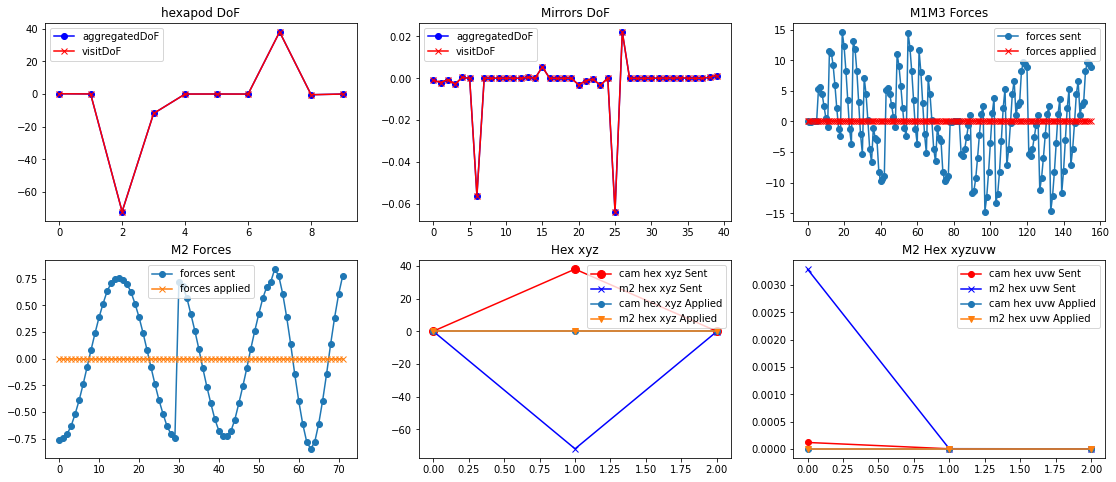

In [23]:
ofc_dict =  await ofcSentApplied(aos, m1m3, m2, camhex, m2hex, make_plot = True)

In [24]:
await aos.cmd_issueCorrection.set_start() 

20: Execute do_issueCorrection().
10: Issue the M2 correction successfully.
10: Issue the camera hexapod correction successfully.
10: Issue the M1M3 correction successfully.
10: Issue the M2 hexapod correction successfully.


DOF event time =  2021-08-11 23:21:22.189891584
If corrections have been issued, we should always expect sent (xxC) to match applied (xxF & xxP)


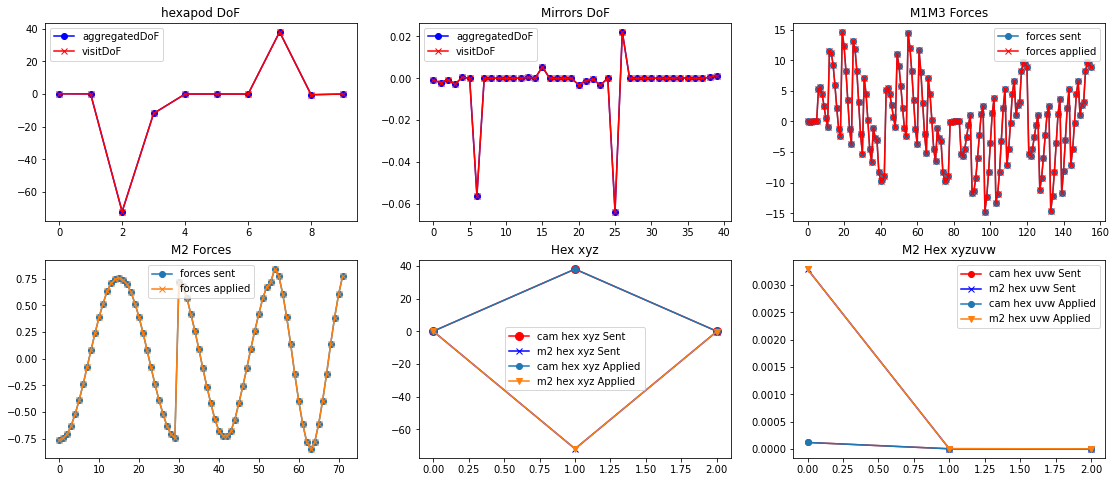

In [25]:
ofc_dict =  await ofcSentApplied(aos, m1m3, m2, camhex, m2hex, make_plot = True)

#### Look at telemetry to verify the changes in the DOFs

In [27]:
end = Time(datetime.now(), scale='tai')
#end = Time('2021-05-14T18:25:30', scale = 'tai')
start = end - timedelta(seconds=100)

dfm = await client.select_time_series('lsst.sal.MTMount.elevation', '*', start, end, csc_index)
dfm1m3 = await client.select_time_series('lsst.sal.MTM1M3.logevent_appliedActiveOpticForces', '*', start, end, csc_index)
dfm2 = await client.select_time_series('lsst.sal.MTM2.axialForce', '*', start, end, csc_index)
dfh = await client.select_time_series('lsst.sal.MTHexapod.logevent_uncompensatedPosition', '*', start, end, csc_index)

idx1=dfh.MTHexapodID==1
dfh1 = dfh[idx1]
idx2=dfh.MTHexapodID==2
dfh2 = dfh[idx2]

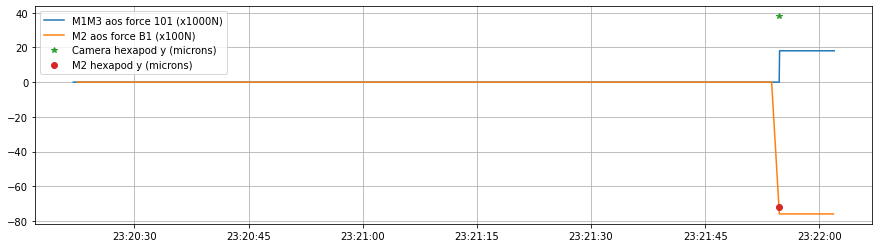

In [28]:
fig, ax = plt.subplots(1,1, figsize=(15,4))
#plt.plot(dfm.actualPosition, '--', label='mount elevation')
plt.plot(dfm1m3.zForces0*1e3, label='M1M3 aos force 101 (x1000N)')
plt.plot(dfm2.applied0*1e2, label='M2 aos force B1 (x100N)')
plt.plot(dfh1.y, '*', label='Camera hexapod y (microns)')
plt.plot(dfh2.y, 'o', label='M2 hexapod y (microns)')
plt.grid()
plt.legend()

### Step 2: disable M2 hexapod, then try to add same aberrations again. The corrections will be rejected by M2 hexapod.

In [29]:
#put M2 hexapod in DISABLED state (so that we can test command rejection)
await salobj.set_summary_state(m2hex, salobj.State.DISABLED)

[<State.ENABLED: 2>, <State.DISABLED: 1>]

In [30]:
#rejection only happens when we issue corrections
await aos.cmd_addAberration.set_start(wf = zernikes, config=config_yaml)

10: Customizing OFC parameters.
10: Overriding ofc_data parameter xref.
10: Currently configured with comcam instrument.
10: Assuming white light filter to compute aberration.
10: Restoring ofc_data values.
10: Overriding ofc_data parameter xref.
20: Execute pubEvent_degreeOfFreedom().
20: Execute pubEvent_m2HexapodCorrection().
20: Execute pubEvent_cameraHexapodCorrection().
20: Execute pubEvent_m1m3Correction().
20: Execute pubEvent_m2Correction().


DOF event time =  2021-08-11 23:23:20.946674688
If corrections have been issued, we should always expect sent (xxC) to match applied (xxF & xxP)


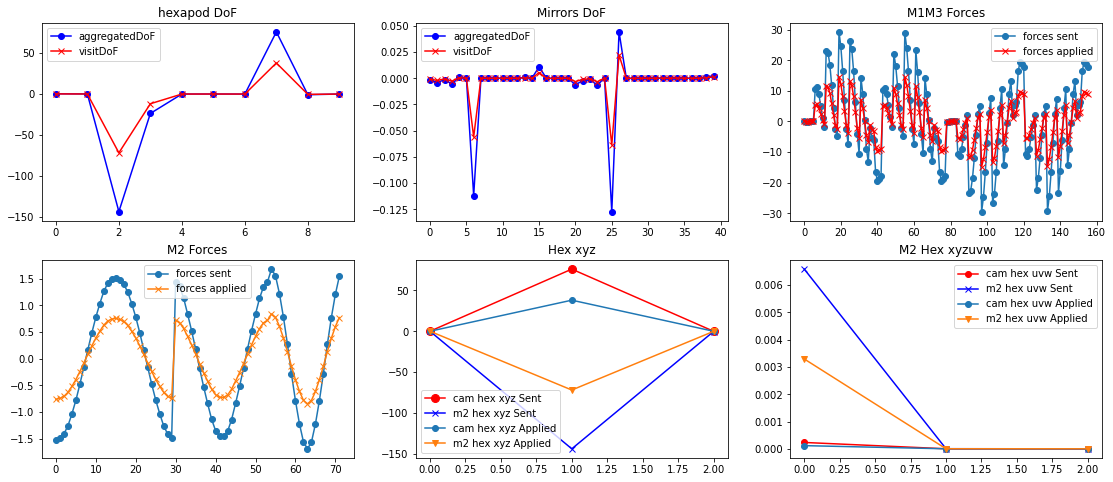

In [31]:
ofc_dict2 =  await ofcSentApplied(aos, m1m3, m2, camhex, m2hex, make_plot = True)

In [32]:
#expect to see an error with this command
await aos.cmd_issueCorrection.set_start() 

20: Execute do_issueCorrection().
40: M2 hexapod correction command failed.
20: Execute pubEvent_rejectedM2HexapodCorrection().
10: Issue the camera hexapod correction successfully.
10: Issue the M1M3 correction successfully.
10: Issue the M2 correction successfully.
20: Execute pubEvent_rejectedDegreeOfFreedom().
30: Undoing camhex correction.
10: Issue the camera hexapod correction successfully.
30: Undoing m1m3 correction.
10: Issue the M1M3 correction successfully.
30: Undoing m2 correction.
10: Issue the M2 correction successfully.


AckError: msg='Command failed', ackcmd=(ackcmd private_seqNum=763213321, ack=<SalRetCode.CMD_FAILED: -302>, error=1, result="Failed: Failed to apply correction to: ['m2hex']. ")

40: Callback <bound method MTAOS.do_issueCorrection of <lsst.ts.MTAOS.mtaos.MTAOS object at 0x7fdd702a5f40>> failed with data=private_revCode: 29ef8f2b, private_sndStamp: 1628724242.0651803, private_rcvStamp: 1628724242.065742, private_seqNum: 763213321, private_identity: Script:7, private_origin: 5336, private_host: 0


DOF event time =  2021-08-11 23:23:20.946674688
If corrections have been issued, we should always expect sent (xxC) to match applied (xxF & xxP)


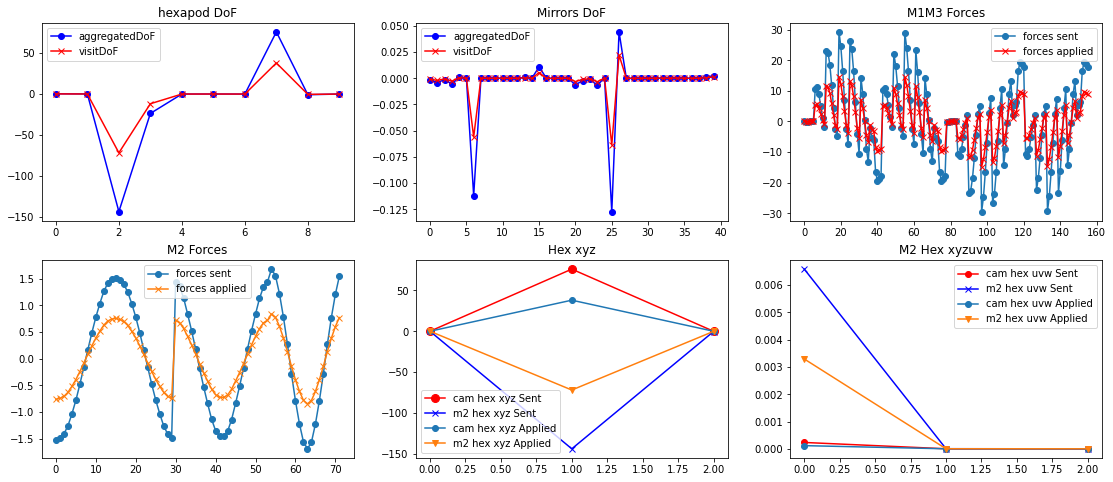

In [33]:
ofc_dict2 = await ofcSentApplied(aos, m1m3, m2, camhex, m2hex, make_plot=True)

#### What to expect from the above plot? Everything on the component side is undone, and the corrections are rejected.

Ref:
https://github.com/lsst-ts/ts_MTAOS/blob/a420c25ab868a932c2cbc6fd45fcbb66f0176c65/python/lsst/ts/MTAOS/mtaos.py#L268

For now, let's examine what happened during and after the rejection.

In [49]:
lastCmd = await aos.evt_rejectedM2HexapodCorrection.aget(timeout=5.)
end = Time(pd.to_datetime(lastCmd.private_sndStamp+0.5, unit='s'), scale= 'tai')
start = end - timedelta(seconds=1)

dfissue = await client.select_time_series('lsst.sal.MTAOS.command_issueCorrection', '*', start, end, csc_index)

dfdof = await client.select_time_series('lsst.sal.MTAOS.logevent_degreeOfFreedom', '*', 
                                        start-timedelta(minutes=30), end, csc_index) #this is from earlier
dfreject = await client.select_time_series('lsst.sal.MTAOS.logevent_rejectedDegreeOfFreedom', '*', start, end, csc_index)

dfC = await client.select_time_series('lsst.sal.MTAOS.logevent_m2HexapodCorrection', '*', start, end, csc_index)
dfCm2 = await client.select_time_series('lsst.sal.MTAOS.logevent_m2Correction', '*', start, end, csc_index)
dfrejectC = await client.select_time_series('lsst.sal.MTAOS.logevent_rejectedM2HexapodCorrection', '*', start, end, csc_index)

cmdm1m3 = await client.select_time_series('lsst.sal.MTM1M3.command_applyActiveOpticForces', '*', start, end, csc_index)
cmdm2 = await client.select_time_series('lsst.sal.MTM2.command_applyForces', '*', start, end, csc_index)
dfh = await client.select_time_series('lsst.sal.MTHexapod.command_move', '*', start, end, csc_index)

idx1=dfh.MTHexapodID==1
cmdh1 = dfh[idx1]
idx2=dfh.MTHexapodID==2
cmdh2 = dfh[idx2]

dfm1m3 = await client.select_time_series('lsst.sal.MTM1M3.logevent_appliedActiveOpticForces', '*', start, end, csc_index)
dfm2 = await client.select_time_series('lsst.sal.MTM2.axialForce', '*', 
                                       start-timedelta(seconds=0.5), end+timedelta(seconds=0.5), csc_index)
dfh = await client.select_time_series('lsst.sal.MTHexapod.logevent_uncompensatedPosition', '*', start, end, csc_index)

idx1=dfh.MTHexapodID==1
dfh1 = dfh[idx1]
idx2=dfh.MTHexapodID==2
dfh2 = dfh[idx2]

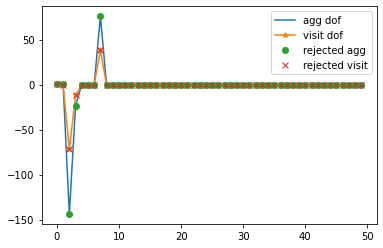

In [47]:
#check that the rejected DOF matches the latest DOF event
a1=np.array([dfdof['aggregatedDoF%d'%i][-1] for i in range(50)])
v1=np.array([dfdof['visitDoF%d'%i][-1] for i in range(50)])
a2=np.array([dfreject['aggregatedDoF%d'%i][-1] for i in range(50)])
v2=np.array([dfreject['visitDoF%d'%i][-1] for i in range(50)])
plt.plot(a1, label='agg dof')
plt.plot(v1,'-*', label='visit dof')
plt.plot(a2,'o', label='rejected agg')
plt.plot(v2,'x', label='rejected visit')
plt.legend()

In [50]:
#in M2 simulator, we only publish telemetry at 1Hz; This makes it impossible to see if M2 forces changed or not.
dfm2

,applied0,applied1,applied10,applied11,applied12,applied13,applied14,applied15,applied16,applied17,...,measured9,private_efdStamp,private_host,private_identity,private_kafkaStamp,private_origin,private_rcvStamp,private_revCode,private_seqNum,private_sndStamp
2021-08-11 23:24:01.359000+00:00,-0.759188,-0.741219,0.388421,0.516322,0.631318,0.708520,0.744668,0.758325,0.737644,0.699377,...,182.883001,1.628724e+09,0,MTM2,1.628724e+09,15379,1.628724e+09,1272f82f,1213898,1.628724e+09
2021-08-11 23:24:02.372000+00:00,-1.518376,-1.482438,0.776841,1.032645,1.262636,1.417041,1.489336,1.516651,1.475287,1.398754,...,184.347947,1.628724e+09,0,MTM2,1.628724e+09,15379,1.628724e+09,1272f82f,1213899,1.628724e+09


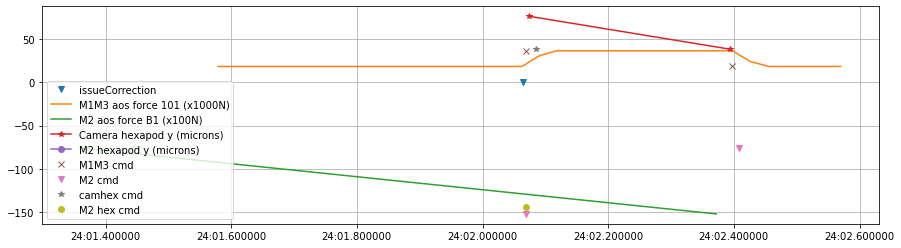

In [58]:
fig, ax = plt.subplots(1,1, figsize=(15,4))
plt.plot(dfissue.private_host,'v',label='issueCorrection')
plt.plot(dfm1m3.zForces0*1e3, label='M1M3 aos force 101 (x1000N)')
plt.plot(dfm2.applied0*1e2, label='M2 aos force B1 (x100N)')
plt.plot(dfh1.y, '-*', label='Camera hexapod y (microns)')
plt.plot(dfh2.y, '-o', label='M2 hexapod y (microns)')
plt.plot(cmdm1m3.zForces0*1e3,'x', label='M1M3 cmd')
plt.plot(cmdm2.axial0*1e2,'v', label='M2 cmd')
plt.plot(cmdh1.y,'*', label='camhex cmd')
plt.plot(cmdh2.y,'o', label='M2 hex cmd')
plt.grid()
plt.legend()

camhex `evt_uncompensatedPosition` comes before `cmd_move`? Time synchronization issue? Do we need to care?

No command issued when undoing camera hexapod?

In [54]:
cmdh1

,MTHexapodID,private_efdStamp,private_host,private_identity,private_kafkaStamp,private_origin,private_rcvStamp,private_revCode,private_seqNum,private_sndStamp,sync,u,v,w,x,y,z
2021-08-11 23:24:02.085000+00:00,1,1.628724e+09,0,MTAOS,1.628724e+09,5028,1.628724e+09,dad43319,1116468789,1.628724e+09,True,0.000117,6.679176e-07,0,0.02515,37.968733,-0.008265


In [53]:
#we did not even issue M2 hex command; we checked M2 hex status before we issue the cmd
cmdh2

,MTHexapodID,private_efdStamp,private_host,private_identity,private_kafkaStamp,private_origin,private_rcvStamp,private_revCode,private_seqNum,private_sndStamp,sync,u,v,w,x,y,z
2021-08-11 23:24:02.069000+00:00,2,1.628724e+09,0,MTAOS,1.628724e+09,5028,1.628724e+09,dad43319,1049971199,1.628724e+09,True,0.006587,0.000005,0,-0.109839,-143.704721,-0.338241


### Step 3. Fix the issue, and re-issue the corrections

Previous corrections have been rejected using `cmd_rejectCorrection`, as part of the error handling. 
We need to do `cmd_addAberration` again.
(even though there is no updated events such as `aos.evt_m1m3Correction`)

Ref:
https://github.com/lsst-ts/ts_MTAOS/blob/a420c25ab868a932c2cbc6fd45fcbb66f0176c65/python/lsst/ts/MTAOS/mtaos.py#L533

In [59]:
#fix the issue
await salobj.set_summary_state(m2hex, salobj.State.ENABLED, settingsToApply="default")

[<State.DISABLED: 1>, <State.ENABLED: 2>]

In [60]:
await readyHexaForAOS(m2hex)

settingsVersion =  default.yaml:v0.7.4-0-g70e7a58 2021-07-28 17:36:48.231204864
pivot at (0, 0, 500000) microns 
maxXY =  10500.0 microns, maxZ=  8900.0  microns
maxUV =  0.175 deg, maxW=  0.05  deg
compsensation mode enabled? True 2021-08-12 00:54:11.722697728
hexa in position? True 2021-08-12 00:54:11.729574144
Current Hexapod position
     -2.71    -270.35     288.51  -0.003236  -0.000000  -0.000000
Uncompensated position
      0.00       0.00       0.00      0.000000   0.000000   0.000000    2021-08-12 00:54:12.032652544
Compensated position
     -2.74    -270.37     288.52      -0.003236   0.000000   0.000000    2021-08-12 00:54:12.032892416
Does the hexapod has enough inputs to do LUT compensation? (If the below times out, we do not.)
mount elevation =  75.0
mount azimth =  0.0
rotator angle =  0.0
? temperature =  0.0
x,y,z,u,v,w =  -2.7378341010400375 -270.36866857539064 288.51589440595694 -0.003236147000060546 0.0 0.0


In [75]:
await aos.cmd_addAberration.set_start(wf = zernikes, config=config_yaml)

10: Customizing OFC parameters.
10: Overriding ofc_data parameter xref.
10: Currently configured with comcam instrument.
10: Assuming white light filter to compute aberration.
10: Restoring ofc_data values.
10: Overriding ofc_data parameter xref.
20: Execute pubEvent_degreeOfFreedom().
20: Execute pubEvent_m2HexapodCorrection().
20: Execute pubEvent_cameraHexapodCorrection().
20: Execute pubEvent_m1m3Correction().
20: Execute pubEvent_m2Correction().


In [76]:
await aos.cmd_issueCorrection.set_start() 

20: Execute do_issueCorrection().
10: Issue the M1M3 correction successfully.
10: Issue the camera hexapod correction successfully.
10: Issue the M2 correction successfully.
10: Issue the M2 hexapod correction successfully.


DOF event time =  2021-08-12 01:12:07.668326912
If corrections have been issued, we should always expect sent (xxC) to match applied (xxF & xxP)


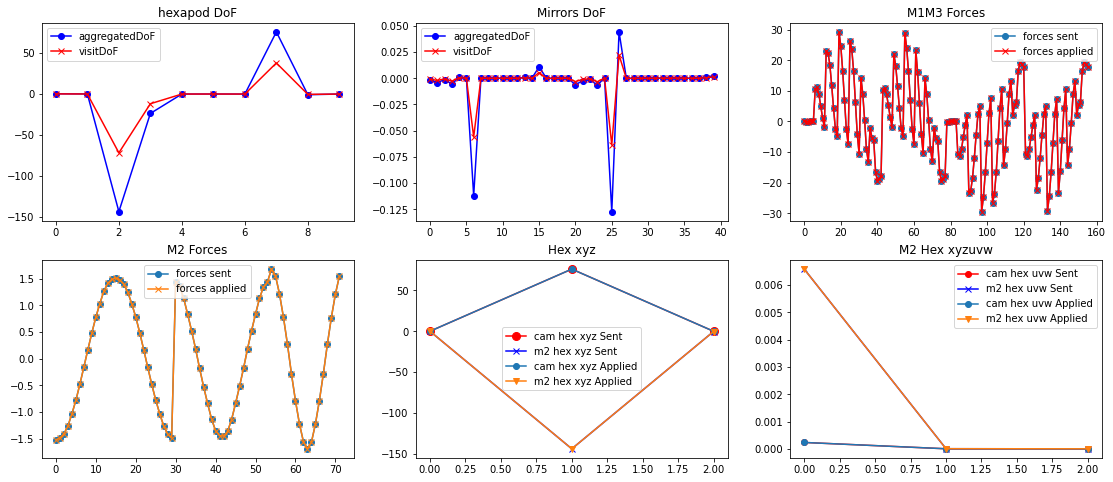

In [77]:
ofc_dict3 = await ofcSentApplied(aos, m1m3, m2, camhex, m2hex, make_plot=True)

In [79]:
config_yaml

'xref: x0\n'

This depends on the control strategy we are using. For x00, do not expect 2 or 1.

In [80]:
ofc_dict['visit_dof'][2], ofc_dict3['visit_dof'][2]

(-71.85236026124905, -71.85236026124905)

In [81]:
#expect 2
ofc_dict3['camhexC'][:5]/ofc_dict['camhexC'][:5]

array([2., 2., 2., 2., 2.])

In [82]:
#expect 2
ofc_dict3['m2hexC'][:5]/ofc_dict['m2hexC'][:5]

array([2., 2., 2., 2., 2.])

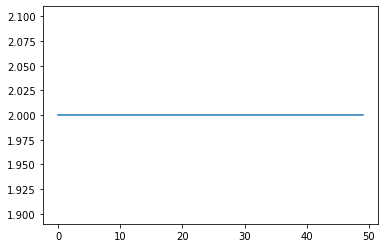

In [83]:
#expect 2
plt.plot(ofc_dict3['aggregated_dof']/ofc_dict['aggregated_dof'])

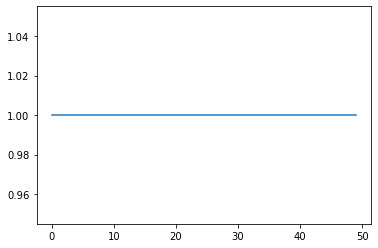

In [84]:
#expect 1
plt.plot(ofc_dict3['visit_dof']/ofc_dict['visit_dof'])

### Step 4. Reject the last `cmd_addAberration`.

If the corrections were applied successfully, and we want to recalculate the corrections, we need to do `cmd_rejectCorrection` first.
`cmd_rejectCorrection` resets the `aggregatedDOF` back to last visit, then we can recalculate the corrections
If the corrections had been applied without error, this will supersede the corrections on the component side as well.

Ref:
https://github.com/lsst-ts/ts_MTAOS/blob/a420c25ab868a932c2cbc6fd45fcbb66f0176c65/python/lsst/ts/MTAOS/mtaos.py#L300

If we simply want to revert back to the system state from last visit, just do `cmd_issueCorrection` after `cmd_rejectCorrection`.

If after `cmd_rejectCorrection`, we simply want to look at the wavefront measurements, and say, I want to try adding 1um of M1M3 bending #5. How do I do that? This is unlikely, because the better thing to do is to let OFC determine the magnitude of this bending mode, by freezing all the other DOFs. If you really want to specify a hand-picked number, perhaps the best way is to use a MTAOS controller, to publish correction events, then do `cmd_issueCorrection`.
The correction events include DOF events and correction events.
You will need to write a function. You pass it a 50x1 array for DOF. 
It loads OFC libaries, calculates forces etc, and publish all the events that `cmd_issueCorrection` needs.

In [85]:
await aos.cmd_rejectCorrection.set_start()

20: Execute do_rejectCorrection().
20: Execute pubEvent_rejectedDegreeOfFreedom().


#### has `cmd_rejectCorrection` reverted both DOFs and the corrections to be sent? (it is not expected to change anything on the component side)

DOF event time =  2021-08-12 01:12:07.668326912
If corrections have been issued, we should always expect sent (xxC) to match applied (xxF & xxP)


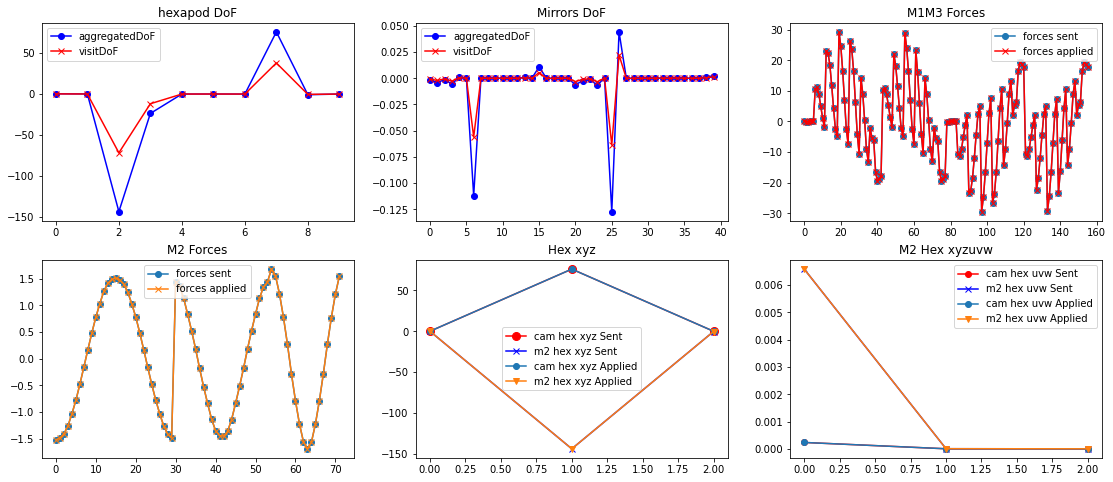

In [86]:
#cmd_rejectCorrection does not publish new DOF event. Should it?
ofc_dict4 =  await ofcSentApplied(aos, m1m3, m2, camhex, m2hex, make_plot = True)

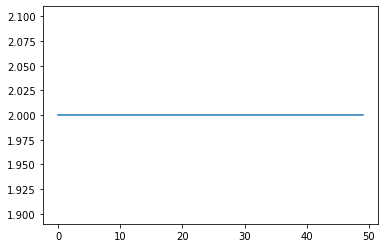

In [87]:
#expect this to be 1.
plt.plot(ofc_dict4['aggregated_dof']/ofc_dict['aggregated_dof'])

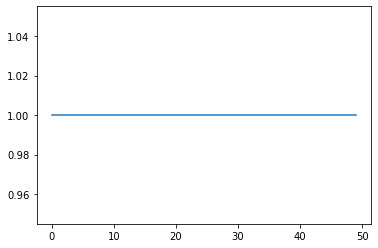

In [88]:
#expect this to be 1/2.
plt.plot(ofc_dict4['aggregated_dof']/ofc_dict3['aggregated_dof'])

### Step 5. add twice aberration. The resulting `aggregatedDOF` should be 3 times the original.

In [89]:
zernikes[7-4] = 2 # z7 = 2um

In [90]:
await aos.cmd_addAberration.set_start(wf = zernikes, config=config_yaml)

10: Customizing OFC parameters.
10: Overriding ofc_data parameter xref.
10: Currently configured with comcam instrument.
10: Assuming white light filter to compute aberration.
10: Restoring ofc_data values.
10: Overriding ofc_data parameter xref.
20: Execute pubEvent_degreeOfFreedom().
20: Execute pubEvent_m2HexapodCorrection().
20: Execute pubEvent_cameraHexapodCorrection().
20: Execute pubEvent_m1m3Correction().
20: Execute pubEvent_m2Correction().


In [91]:
await aos.cmd_issueCorrection.set_start()

20: Execute do_issueCorrection().
10: Issue the M2 hexapod correction successfully.
10: Issue the camera hexapod correction successfully.
10: Issue the M1M3 correction successfully.
10: Issue the M2 correction successfully.


DOF event time =  2021-08-12 01:22:20.947701248
If corrections have been issued, we should always expect sent (xxC) to match applied (xxF & xxP)


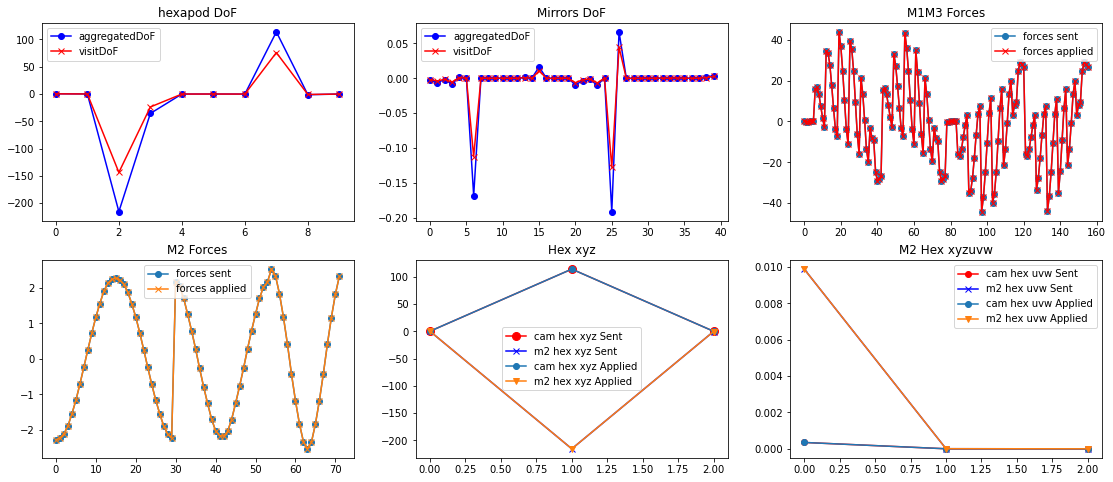

In [92]:
ofc_dict5 =  await ofcSentApplied(aos, m1m3, m2, camhex, m2hex, make_plot = True)

(2.0, 4.0)

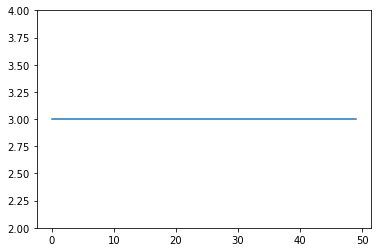

In [94]:
#expect this to be 3.
plt.plot(ofc_dict5['aggregated_dof']/ofc_dict['aggregated_dof'])
plt.ylim([2,4])

### Close up

In [ ]:
#if we started with enabled state, we need to put it back
await salobj.set_summary_state(m1m3, salobj.State.ENABLED,  settingsToApply='Default')

In [144]:
await salobj.set_summary_state(m2, salobj.State.OFFLINE)

[<State.STANDBY: 5>, <State.OFFLINE: 4>]

In [143]:
await salobj.set_summary_state(m1m3, salobj.State.STANDBY)

[<State.ENABLED: 2>, <State.DISABLED: 1>, <State.STANDBY: 5>]

In [131]:
await salobj.set_summary_state(camhex, salobj.State.STANDBY)

[<State.DISABLED: 1>, <State.STANDBY: 5>]

forceActuatorForceWarning DDS read queue is full (100 elements); data may be lost


In [129]:
await salobj.set_summary_state(aos, salobj.State.STANDBY)

[<State.ENABLED: 2>, <State.DISABLED: 1>, <State.STANDBY: 5>]

In [142]:
await lowerM1M3(m1m3)

m1m3 state DetailedState.LOWERING 2021-05-14 19:47:36.387881984
m1m3 state DetailedState.PARKED 2021-05-14 19:49:20.622984960


### Check if the telescope is in tracking mode. If yes, need to stop stacking. 
The alternative is to check "MT Mount status" dash board on Chronograf. Make sure there are three "False".

In [ ]:
mountStatus = await mount.evt_axesInPosition.aget(timeout=5.)
rotStatus = await rot.evt_inPosition.aget(timeout=5.)
trackingStatus = mountStatus.elevation and mountStatus.azimuth and rotStatus.inPosition
print('Are we tracking?', trackingStatus)

In [ ]:
await ptg.cmd_stopTracking.set_start(timeout=5.)